### **Library Imports**

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from time import time

### **Constants and Utilities**

In [2]:
SEED = 42
BASE_PATH = "../input/2022-regression-data-challenge"

def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")

### **Load Data**

In [3]:
train_df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
test_df  = pd.read_csv(os.path.join(BASE_PATH, "test.csv"))
ss_df    = pd.read_csv(os.path.join(BASE_PATH, "submission.csv"))

train_df = train_df.drop(labels=["Id"], axis=1)
test_df  = test_df.drop(labels=["Id"], axis=1)

train_df.head(5)

,score,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
0,34.130,0.00243,0.000018,0.00108,0.00124,0.00323,0.01147,0.105,0.00625,0.00658,...,-0.824511,-1.217875,-0.432389,-1.455320,-0.280675,0.681113,0.375320,0.764563,-0.237859,-0.282198
1,19.000,0.00280,0.000021,0.00087,0.00128,0.00260,0.01575,0.137,0.00812,0.00868,...,0.080466,-0.812559,1.512731,0.070331,2.368754,-0.256309,1.315997,0.093631,-0.389538,1.396095
2,43.104,0.00412,0.000028,0.00162,0.00213,0.00487,0.02644,0.242,0.01150,0.01423,...,-0.060555,-0.027766,-0.123652,0.820478,1.054439,1.922146,-1.262435,2.017997,0.687229,-0.935456
3,38.814,0.00781,0.000043,0.00451,0.00399,0.01353,0.02975,0.261,0.01650,0.01610,...,-0.153332,-1.298289,1.410486,1.950012,0.613255,0.492419,0.124454,0.891332,0.401179,0.383195
4,41.034,0.00488,0.000026,0.00265,0.00251,0.00794,0.04983,0.448,0.02688,0.02876,...,-0.985639,-0.469064,-2.579920,0.173884,-0.330941,0.089597,0.617369,-0.183967,0.408726,1.607871


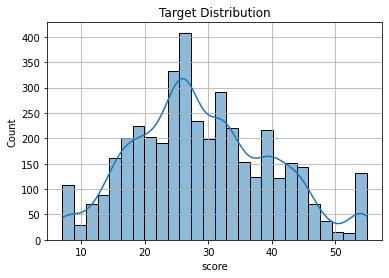

In [4]:
sns.histplot(data=train_df, x="score", kde=True)
plt.grid()
plt.title("Target Distribution")
plt.show()

### **Pipeline Setup**

In [5]:
X, y = train_df.iloc[:, 1:].copy().values, train_df.iloc[:, 0].copy().values

sc_X = StandardScaler()
sc_y = StandardScaler()

### **Helpers**

In [6]:
def train_fn(names: list, n_splits: int, seed: int) -> tuple:
    maes, mses, r2s = [], [], []

    best_mse = np.inf

    breaker()
    start_time = time()
    for name in names:
        fold = 1
        if name == "lir": print(f"Linear Regression\n")
        if name == "knr": print(f"K-Neighbours Regressor\n")
        if name == "dtr": print(f"Decision Tree Regressor\n")
        if name == "etr": print(f"Extra Tree Regressor\n")
        if name == "abr": print(f"AdaBoost Regressor\n")
        if name == "etrs": print(f"Extra Trees Regressor\n")
        if name == "rfr": print(f"Random Forest Regressor\n")
        if name == "gbr": print(f"Gradient Boosting Regressor\n")
        if name == "svr": print(f"Support Vector Regressor\n")
        if name == "xgr": print(f"XGB Regressor\n")
        
        for tr_idx, va_idx in KFold(n_splits=n_splits, random_state=SEED, shuffle=True).split(X):

            print(f"Fold {fold}")
            X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]
            
            X_train = sc_X.fit_transform(X_train)
            X_valid = sc_X.transform(X_valid)

            y_train = sc_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
            y_valid = sc_y.transform(y_valid.reshape(-1, 1)).reshape(-1)

            if name == "lir": model = LinearRegression()
            if name == "knr": model = KNeighborsRegressor()
            if name == "dtr": model = DecisionTreeRegressor(random_state=seed)
            if name == "etr": model = ExtraTreeRegressor(random_state=seed)
            if name == "abr": model = AdaBoostRegressor(random_state=seed)
            if name == "etrs": model = ExtraTreesRegressor(random_state=seed)
            if name == "rfr": model = RandomForestRegressor(random_state=seed)
            if name == "gbr": model = GradientBoostingRegressor(random_state=seed)
            if name == "svr": model = SVR()
            if name == "xgr": model = XGBRegressor(random_state=seed)

            model.fit(X_train, y_train)
            y_pred = sc_y.inverse_transform(model.predict(X_valid).reshape(-1, 1)).reshape(-1)

            mae, mse, r2 = get_scores(sc_y.inverse_transform(y_valid.reshape(-1, 1)).reshape(-1), y_pred)
            print_scores(mae, mse, r2)

            maes.append(mae)
            mses.append(mse)
            r2s.append(r2)

            if mse < best_mse:
                best_model_name = f"{name}_{fold}"

            breaker()

            with open(f"{name}_{fold}.pkl", "wb") as fp: pickle.dump(model, fp)
            fold += 1

    print(f"Time Taken for {n_splits}-CV for {len(names)} different models : {(time()-start_time)/60:.2f} minutes")
    breaker()
    
    return best_model_name, maes, mses, r2s


def get_scores(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    return mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred), r2_score(y_true, y_pred)


def print_scores(mae: float, mse: float, r2: np.ndarray) -> None:
    print(f"MAE  : {mae:.5f}")
    print(f"MSE  : {mse:.5f}")
    print(f"R2   : {mse:.5f}")

### **Train**

In [7]:
names = ["lir", "knr", "dtr", "etr", "abr", "etrs", "gbr", "rfr", "svr", "xgr"]

best_model_name, maes, mses, r2s = train_fn(names, 5, SEED)
print(best_model_name)
breaker()


**************************************************

Linear Regression

Fold 1
MAE  : 8.70516
MSE  : 111.64848
R2   : 111.64848

**************************************************

Fold 2
MAE  : 8.65181
MSE  : 111.77484
R2   : 111.77484

**************************************************

Fold 3
MAE  : 8.29214
MSE  : 103.30216
R2   : 103.30216

**************************************************

Fold 4
MAE  : 8.38366
MSE  : 105.31704
R2   : 105.31704

**************************************************

Fold 5
MAE  : 7.99990
MSE  : 95.04646
R2   : 95.04646

**************************************************

K-Neighbours Regressor

Fold 1
MAE  : 9.25588
MSE  : 131.82531
R2   : 131.82531

**************************************************

Fold 2
MAE  : 9.12121
MSE  : 130.22889
R2   : 130.22889

**************************************************

Fold 3
MAE  : 8.69306
MSE  : 117.45325
R2   : 117.45325

**************************************************

Fold 4
MAE  : 8.57804
MSE  : 116.7

In [8]:
model = pickle.load(open(f"{best_model_name}.pkl", "rb"))
y_pred = sc_y.inverse_transform(model.predict(test_df.copy().values).reshape(-1, 1)).reshape(-1)

ss_df["Expected"] = y_pred
ss_df.to_csv("submission.csv", index=False)